In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from google.colab import drive
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


In [2]:
# Login Google Drive
drive.mount('/content/drive',force_remount=True)
%mkdir -p "/content/drive/My Drive/Colab Notebooks/data"
%cd "/content/drive/My Drive/Colab Notebooks/data"
print("Mounted Drive")

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/data
Mounted Drive


In [3]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("UDOW", start="2010-01-01").reset_index()
df_full.to_csv('UDOW.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-11,6.618333,6.618333,6.615833,6.616667,6.359361,32400
1,2010-02-12,6.592500,6.600833,6.527500,6.593333,6.336934,69600
2,2010-02-16,6.930833,7.036667,6.894166,7.036667,6.763027,50400
3,2010-02-17,7.167500,7.203333,7.145833,7.188334,6.908796,207600
4,2010-02-18,7.217500,7.397500,7.209167,7.374166,7.087402,162000


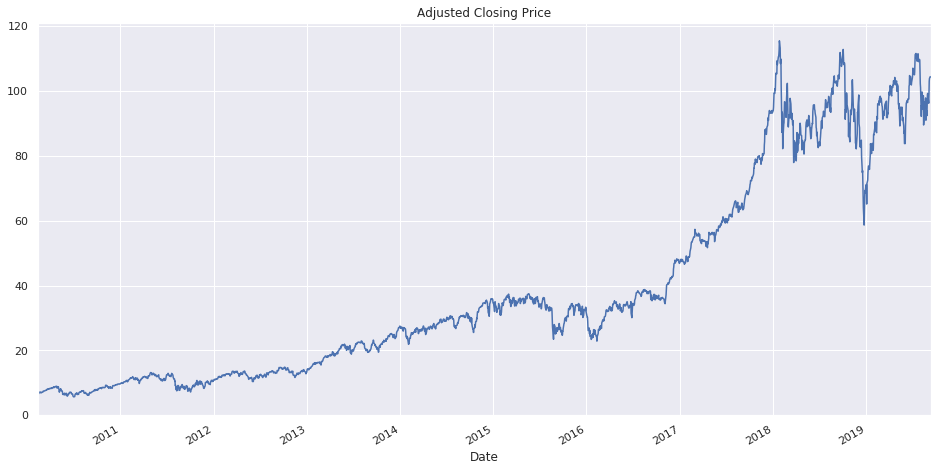

In [4]:
df = df_full.copy()
df.set_index('Date', inplace=True)
df['Adj Close'].plot(label='UDOW', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [5]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)
data = df['Adj Close'].values[indices]

X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

array([[   0,    1,    2, ...,   30,   31,   32],
       [   1,    2,    3, ...,   31,   32,   33],
       [   2,    3,    4, ...,   32,   33,   34],
       ...,
       [2376, 2377, 2378, ..., 2406, 2407, 2408],
       [2377, 2378, 2379, ..., 2407, 2408, 2409],
       [2378, 2379, 2380, ..., 2408, 2409, 2410]])

Train on 1903 samples, validate on 476 samples
Epoch 1/250
1903/1903 [==============================] - 6s 3ms/step - loss: 0.0957 - mean_absolute_error: 0.3665 - val_loss: 0.4252 - val_mean_absolute_error: 0.9144
Epoch 2/250
1903/1903 [==============================] - 4s 2ms/step - loss: 0.0408 - mean_absolute_error: 0.2402 - val_loss: 0.2800 - val_mean_absolute_error: 0.7364
Epoch 3/250
1903/1903 [==============================] - 4s 2ms/step - loss: 0.0166 - mean_absolute_error: 0.1456 - val_loss: 0.0308 - val_mean_absolute_error: 0.2197
Epoch 4/250
1903/1903 [==============================] - 5s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0882 - val_loss: 0.0118 - val_mean_absolute_error: 0.1224
Epoch 5/250
1903/1903 [==============================] - 5s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0634 - val_loss: 0.0665 - val_mean_absolute_error: 0.3395
Epoch 6/250
1903/1903 [==============================] - 5s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0515 - va

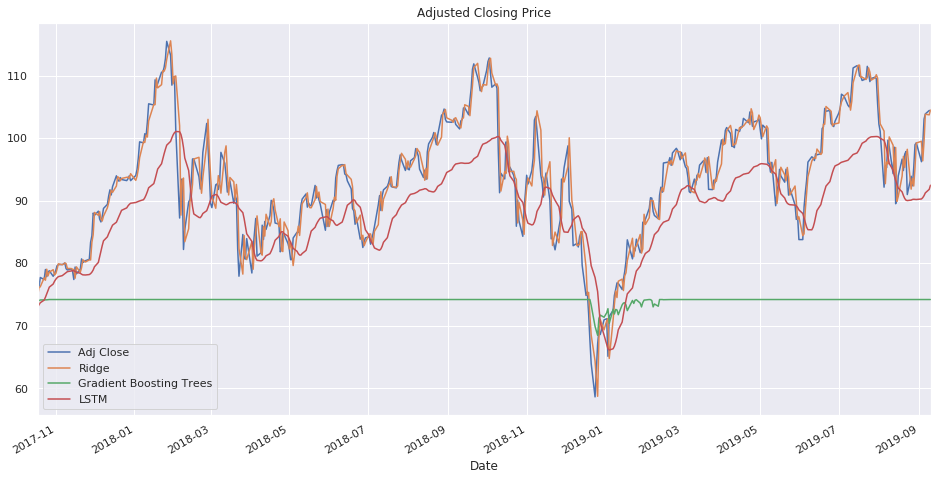

In [25]:
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])
optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))


df_final = df.copy()
df_final.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_final = df_final.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_final['Ridge'] = y_pred_ridge
df_final['Gradient Boosting Trees'] = y_pred_gb
df_final['LSTM'] = y_pred_keras
df_final.plot(label='UDOW', figsize=(16,8), title='Adjusted Closing Price', grid=True)